In [15]:
import torch_geometric
from torch_geometric.datasets import MoleculeNet
import torch
import torch_geometric as pyg
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.nn.conv import GATv2Conv, GATConv, TransformerConv
from torch_geometric.nn.models import MLP
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import BondType, HybridizationType
import os
import matplotlib.pyplot as plt

In [16]:
dataset = MoleculeNet(name="lipo", root="MoleculeNet")

In [17]:
class GCN_N(torch.nn.Module):
    def __init__(self, layer:int, dim=32, dataset=dataset):
        super().__init__()
        self.layer = layer
        self.dataset = dataset
        self.dim = dim
        self.conv1 = GCNConv(self.dataset.num_node_features, self.dim, improved=True)
        self.convn = GCNConv(self.dim, self.dim, improved=True)
        self.out = pyg.nn.Linear(self.dim, 1)

    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        x = x.to(torch.float)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        for i in range(2, self.layer + 1):
            x = self.convn(x, edge_index)
            x = F.relu(x)
        x = pyg.nn.global_add_pool(x, batch) 
        #x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

In [60]:
#データの分割(total: 130831)
num_train, num_val = int(len(dataset)*0.6), int(len(dataset)*0.2)
num_test = len(dataset) - (num_train + num_val)
batch_size = 32

# 乱数の固定
device = torch.device("cpu")
seed = 92345
#pyg.seed_everything(seed=seed)
train_set, valid_set, test_set = random_split(dataset, [num_train, num_val, num_test])

#Dataloaderの生成
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=pyg.seed_everything(seed))
valid_loader = DataLoader(valid_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(seed))
test_loader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(seed))

#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#valid_loader = DataLoader(valid_set, batch_size=batch_size)
#test_loader = DataLoader(test_set, batch_size=batch_size)

layer = 3
dim = 32
model = GCN_N(layer=layer,dim=dim)
# 損失関数
criterion = F.mse_loss
# Optimizerの初期化
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)

(array([ 53., 112., 162., 327., 447., 688., 762., 911., 528., 210.]),
 array([-1.5, -0.9, -0.3,  0.3,  0.9,  1.5,  2.1,  2.7,  3.3,  3.9,  4.5]),
 <BarContainer object of 10 artists>)

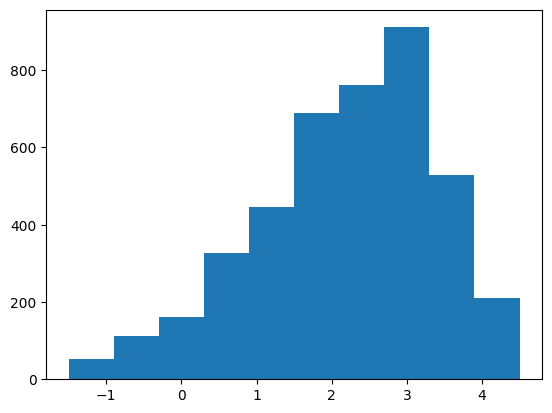

In [5]:
y = [i.item() for i in dataset.y]
plt.hist(y)


In [61]:
from math import sqrt
from sklearn.metrics import r2_score

results = []
for epoch in range(1000):

    # train
    model.train()
    train_loss = 0
    train_R2 = 0
    for batch in train_loader:
        batch = batch.to("cpu")
        optimizer.zero_grad()
        prediction = model(batch)
        #loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
        loss = criterion(prediction, batch.y)
        R2 = r2_score(batch.y.detach().numpy().copy(), prediction.detach().numpy().copy())
        loss.backward()
        train_loss += loss.item()
        train_R2 += R2
        optimizer.step()
    train_loss /=  len(train_loader) #損失の平均(batchあたり) #平均を取ってからルート
    train_loss = sqrt(train_loss)
    train_R2 /= len(train_loader)

    # validation
    model.eval()
    valid_loss = 0
    valid_R2 = 0
    with torch.inference_mode(): # 自動微分無効。torch.no_grad()よりさらに高速化
        for batch in valid_loader:
            prediction = model(batch)
            #loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
            loss = criterion(prediction, batch.y)
            R2 = r2_score(batch.y.detach().numpy().copy(), prediction.detach().numpy().copy())
            valid_loss += loss.item()
            valid_R2 += R2
    valid_loss /= len(valid_loader)
    valid_loss = sqrt(valid_loss)
    valid_R2 /= len(valid_loader)

    results.append([train_loss, train_R2, valid_loss, valid_R2])
    print(f"Epoch {epoch+1} | train_loss:{train_loss} (R2={train_R2}), valid_loss:{valid_loss} (R2={valid_R2})")
    #loss_three_50.append({"Epoch":epoch + 1 , "train_loss":train_loss, "valid_loss":valid_loss})

Epoch 1 | train_loss:1.484056602553001 (R2=-0.5933342177874826), valid_loss:1.190439651359937 (R2=-0.08372090235565917)
Epoch 2 | train_loss:1.212721234672357 (R2=-0.08136743008308191), valid_loss:1.1287088609031772 (R2=0.03005035878933353)
Epoch 3 | train_loss:1.1919124065587867 (R2=-0.02191204124652687), valid_loss:1.101158890809203 (R2=0.08009216857056715)
Epoch 4 | train_loss:1.159432024879126 (R2=0.017115640663928126), valid_loss:1.1004326088096512 (R2=0.08297712889637285)
Epoch 5 | train_loss:1.1488661892684167 (R2=0.032153946251662506), valid_loss:1.12910289388812 (R2=0.038026290859858015)
Epoch 6 | train_loss:1.1925925968190163 (R2=-0.033130661154393594), valid_loss:1.1271793503993466 (R2=0.04105832878620353)
Epoch 7 | train_loss:1.1698988100461347 (R2=-0.009606751393997432), valid_loss:1.1045474799261263 (R2=0.07649266885573092)
Epoch 8 | train_loss:1.1435232326082998 (R2=0.027847711044696844), valid_loss:1.0901799839784692 (R2=0.10253055596432585)
Epoch 9 | train_loss:1.13674

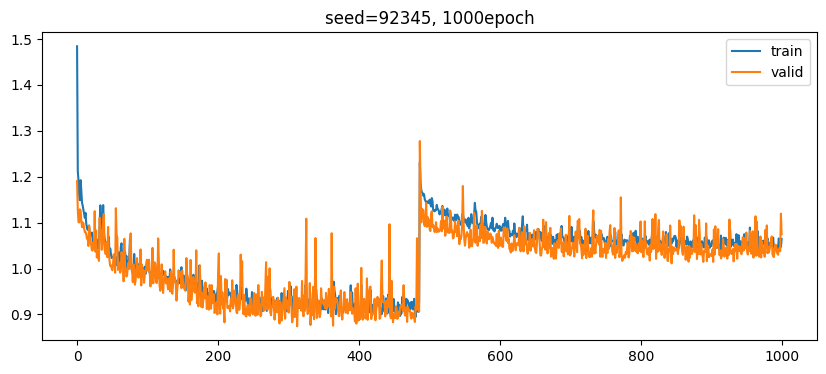

In [68]:
plt.figure(figsize=(10,4))
plt.plot([i for i in range(len(results))], [result[0] for result in results], label="train")
#ax2.plot([i for i in range(len(results))], [result[1] for result in results])
plt.plot([i for i in range(len(results))], [result[2] for result in results], label="valid")
#ax2.plot([i for i in range(len(results))], [result[3] for result in results])
plt.title("seed=92345, 1000epoch")
plt.legend()